In [1]:
import sys 
print(sys.version)


3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]


# Supervisor

In [2]:
!poetry add langchain_experimental

The following packages are already present in the pyproject.toml and will be skipped:

  • langchain_experimental

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [1]:
from langchain.globals import set_debug, set_verbose

set_verbose(True)
set_debug(True)


from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_experimental.llms.ollama_functions import OllamaFunctions

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

import warnings
warnings.filterwarnings("ignore")

# members = ["Food_crew", "General_conversation", "General_other", "Mediwave_rag", "Travel_crew"]


members = ["Food_crew", "General_conv", "General_other", "Mediwave_rag", ]

system_prompt = (
    """You are a supervisor tasked with managing a conversation between the
     following workers:  {members}. Given the following user request,"
     respond with the worker to act next. 
     
     if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew',
    if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag',    
    if the user makes conversation, jokes and funny conversations then use 'General_conv',
    if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other',
    if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew'
        
    Each worker will perform a
     task and respond with their results and status. When finished,
    respond with FINISH."""
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role to act",
    
    "parameters": {
        "type": "object",        
        "properties": {
            "next": {
                "type": "string",
                "enum": f"{options}",
            }
        },
        "required": ["next"],
    },
}


DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": "route",
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
""" 


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = OllamaFunctions(
    model="openhermes:7b-mistral-v2-q8_0",
    tool_system_prompt_template=DEFAULT_SYSTEM_TEMPLATE
    )


def supervisor_node(state):

    
    supervisor_chain = (
        prompt
        | llm.bind(functions=[function_def], function_call={"name": "route"})
        | JsonOutputFunctionsParser()
    )
        
    result = supervisor_chain.invoke(state)
    
    return result





import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str



# from grp_travel_crew_ai.grp_travel_crewai import travel_crew

from grp_RAG1.grp_rag1_rag import mediwave_rag

from grp_others.grp_others_graph import grp_other_def as gen_others

from grp_food_crew_ai.grp_food_crewai import food_crew

from grp_Gen_Conv.grp_gen_conv_chain import general_conversation



workflow = StateGraph(AgentState)

workflow.add_node("Food_crew", food_crew)
workflow.add_node("General_conv", general_conversation)
workflow.add_node("General_other", gen_others)
workflow.add_node("Mediwave_rag", mediwave_rag)
# workflow.add_node("Travel_crew", travel_crew)

workflow.add_node("supervisor", supervisor_node)




for member in members:
    
    if member == 'Mediwave_rag':
        continue
    
    
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
    

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes


conditional_map = {k: k for k in members}



conditional_map["FINISH"] = END
# conditional_map['supervisor'] ='supervisor'

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("supervisor")
workflow.set_finish_point('Mediwave_rag')
workflow.set_finish_point('General_conv')


graph = workflow.compile()


Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ig

In [2]:
#  "kwargs": {
#             "content": "{\n  \"tool\": \"route\",\n  \"tool_input\": {\n    \"next\": \"Mediwave_rag\"\n  }\n}"
#           }

# "kwargs": {
#             "content": "{\n  \"tool\": \"route\",\n  \"tool_input\": \"General_conv\"\n}"
#           }

In [2]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="how to make vanilla sponge cake"
            )
        ],
    },
    config= {"recursion_limit": 100},
    
    debug=True,
):
    if "__end__" not in s:
        print(s)
        print("---")


[chain/start] [1:chain:LangGraph] Entering Chain run with input:
{
  "input": ""
}
[langgraph/step] Starting step 0 with 1 task. Next tasks:
- __start__({'messages': [HumanMessage(content='how to make vanilla sponge cake')]})
[chain/start] [1:chain:LangGraph > 2:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 2:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 3:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 3:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 4:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 4:chain:__start__] s] Exiting Chain run with output:
[outputs]
[langgraph/checkpoint] Finishing step 0. Channel values:
{'__start__': {'messages': [...]},
 <ReservedChannels.is_last_step: 'is_last_step'>: False,
 'messages': [HumanMessage(content='how to make vanilla

ValidationError: 20 validation errors for Crew
manager_callbacks.0
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('formatting_errors', 0), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.1
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('id', UUID('de57d057-0d0...056-8d0d-d2f7994b4ef3')), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.2
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('role', 'Head of the crew'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.3
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('goal', '\nassinging the...out come of the task\n'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.4
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('backstory', 'Expert in ... to the fellow members'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.5
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('config', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.6
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('max_rpm', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.7
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('memory', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.8
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('verbose', True), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.9
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('allow_delegation', True), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.10
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('tools', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.11
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('max_iter', 15), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.12
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('agent_executor', CrewAg...swer_max_iterations=13)), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.13
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('tools_handler', <crewai...ject at 0x7fe4cb8c4dd0>), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.14
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('cache_handler', <crewai...ject at 0x7fe4cd1d9450>), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.15
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('step_callback', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.16
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('i18n', I18N(language='en')), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.17
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('llm', Ollama(model='ope...es:7b-mistral-v2-q8_0')), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.18
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('function_calling_llm', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of
manager_callbacks.19
  Input should be an instance of BaseCallbackHandler [type=is_instance_of, input_value=('callbacks', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.6/v/is_instance_of

In [4]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="tell me about robert downey jr use wikipedia"
            )
        ],
    },
    config= {"recursion_limit": 25},
    
    debug=True,
):
    if "__end__" not in s:
        print(s)
        print("---")


[chain/start] [1:chain:LangGraph] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [1:chain:LangGraph > 2:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 2:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 3:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 3:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 4:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 4:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 5:chain:__start__:edges] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 5:chain:__start__:edges] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 6:chain:supervisor] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:LangGraph > 6:chain:supervi

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [11]:
graph.invoke({
        "messages": [
            HumanMessage(
                content="tell me jokr."
            )
        ],
    })

[chain/start] [1:chain:LangGraph] Entering Chain run with input:
{
  "input": ""
}
[pregel/step] Starting step 0 with 1 task. Next tasks:
- __start__({'messages': [HumanMessage(content='tell me jokr.')]})
[chain/start] [1:chain:LangGraph > 2:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 2:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 3:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 3:chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [1:chain:LangGraph > 4:chain:__start__] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:LangGraph > 4:chain:__start__] s] Exiting Chain run with output:
[outputs]
[pregel/checkpoint] Finishing step 0. Channel values:
{'__start__': {...},
 '__start__:inbox': {...},
 <ReservedChannels.is_last_step: 'is_last_step'>: False,
 'messages': [...]}
[pregel/step] Starting step 1 with 1 task. Nex

/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(
/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


[chain/start] [1:chain:LangGraph > 46:chain:General_conv > 48:chain:general_conversation > 49:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 46:chain:General_conv > 48:chain:general_conversation > 49:chain:RunnableSequence > 50:chain:RunnableParallel<question>] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 46:chain:General_conv > 48:chain:general_conversation > 49:chain:RunnableSequence > 50:chain:RunnableParallel<question> > 51:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 46:chain:General_conv > 48:chain:general_conversation > 49:chain:RunnableSequence > 50:chain:RunnableParallel<question> > 51:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 46:chain:General_conv > 48:chain:general_conversation > 49:chain:Runn

/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(
/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


[chain/start] [1:chain:LangGraph > 98:chain:General_conv > 100:chain:general_conversation > 101:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 98:chain:General_conv > 100:chain:general_conversation > 101:chain:RunnableSequence > 102:chain:RunnableParallel<question>] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 98:chain:General_conv > 100:chain:general_conversation > 101:chain:RunnableSequence > 102:chain:RunnableParallel<question> > 103:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 98:chain:General_conv > 100:chain:general_conversation > 101:chain:RunnableSequence > 102:chain:RunnableParallel<question> > 103:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 98:chain:General_conv > 100:chain:general_conversation >

/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


[chain/start] [1:chain:LangGraph > 150:chain:General_conv > 152:chain:general_conversation > 153:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 150:chain:General_conv > 152:chain:general_conversation > 153:chain:RunnableSequence > 154:chain:RunnableParallel<question>] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/start] [1:chain:LangGraph > 150:chain:General_conv > 152:chain:general_conversation > 153:chain:RunnableSequence > 154:chain:RunnableParallel<question> > 155:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 150:chain:General_conv > 152:chain:general_conversation > 153:chain:RunnableSequence > 154:chain:RunnableParallel<question> > 155:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "tell me jokr."
}
[chain/end] [1:chain:LangGraph > 150:chain:General_conv > 152:chain:general_conversat

/home/amaithi/anaconda3/envs/lang/lib/python3.10/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.1. The latest version is 4.5.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [9]:
from grp_others.grp_others_graph import graph_others as gen_others



result = gen_others.invoke({'input': 'tell me about robert downey jr use wikipedia'})

Called `execute_tools`
Calling tool: wikipedia_search
Called `execute_tools`
Calling tool: wikipedia_search
Called `execute_tools`
Calling tool: wikipedia_search


In [46]:

from langchain.agents.agent import AgentOutputParser

from operator import itemgetter 
from langchain.agents.output_parsers import ReActSingleInputOutputParser

value = result['agent_outcome'].return_values['output']
value

'Robert John Downey Jr. is an American actor who was born on April 4, 1965. He has starred in numerous films, such as Iron Man, Sherlock Holmes, and Tropic Thunder. He has also faced personal struggles throughout his life, including substance abuse issues.'

TypeError: BaseOutputParser.invoke() missing 1 required positional argument: 'self'

In [ ]:
state = {'input': 'tell me about robert downey jr use wikipedia',
 'chat_history': None,
 'agent_outcome': AgentFinish(return_values={'output': 'Robert Downey Jr. is an American actor who has starred in popular movies such as Iron Man 2, Sherlock Holmes (2009 film), and various films within the Marvel Cinematic Universe.'}, log='I need to summarize the information about Robert Downey Jr. and his popular movies.\nFinal Answer: Robert Downey Jr. is an American actor who has starred in popular movies such as Iron Man 2, Sherlock Holmes (2009 film), and various films within the Marvel Cinematic Universe.'),
 'intermediate_steps': [(AgentAction(tool='wikipedia_search', tool_input='Robert Downey Jr.', log='I need to search Robert Downey Jr. on Wikipedia.\nAction: wikipedia_search\nAction Input: Robert Downey Jr.'),
   'Page: Robert Downey Jr.\nSummary: Robert John Downey Jr. (born April 4, 1965) is an American actor. H'),
  (AgentAction(tool='wikipedia_search', tool_input='Robert Downey Jr. filmography', log='I need to get more information about his acting career and movies.\nAction: wikipedia_search\nAction Input: Robert Downey Jr. filmography'),
   'Page: Robert Downey Jr. filmography\nSummary: Robert Downey Jr. is an American actor who has starred '),
  (AgentAction(tool='wikipedia_search', tool_input='Iron Man (film)', log='I need to know what are some popular movies he has been in.\nAction: wikipedia_search\nAction Input: Iron Man (film)'),
   'Page: Iron Man 2\nSummary: Iron Man 2 is a 2010 American superhero film based on the Marvel Comics ch'),
  (AgentAction(tool='wikipedia_search', tool_input='Sherlock Holmes (film)', log='I need to know what are some other popular movies he has been in.\nAction: wikipedia_search\nAction Input: Sherlock Holmes (film)'),
   'Page: Sherlock Holmes (2009 film)\nSummary: Sherlock Holmes is a 2009 period mystery action film star'),
  (AgentAction(tool='wikipedia_search', tool_input='Avengers (film series)', log='I need to know what are some other popular movies he has been in.\nAction: wikipedia_search\nAction Input: Avengers (film series)'),
   'Page: List of Marvel Cinematic Universe films\nSummary: The Marvel Cinematic Universe (MCU) films are')]}

In [5]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.tools import BaseTool, StructuredTool, tool


from langchain_core.pydantic_v1 import BaseModel, Field


api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)

class WikiInputs(BaseModel):
    """Inputs to the wikipedia tool."""

    query: str = Field(
        description="query to look up in Wikipedia, should be 3 or less words"
    )
    
def wiki_func(query):
    
    wiki = WikipediaQueryRun(
        name="wikipedia_search",
        description="wikipedia_search - to search things in wikipedia",
        args_schema=WikiInputs,
        api_wrapper=api_wrapper,
        return_direct=True,
    )
    
    wiki.

wiki = StructuredTool.from_function(
    func=WikipediaQueryRun,
    name='Weather',
    description="useful for getting the current weather data about a partidular given location",
    handle_tool_error=True
)

ValueError: Value not declarable with JSON Schema, field: name='callback_manager' type=Optional[BaseCallbackManager] required=False default=None

In [6]:
wiki = WikipediaQueryRun(
        name="wikipedia_search",
        description="wikipedia_search - to search things in wikipedia",
        args_schema=WikiInputs,
        api_wrapper=api_wrapper,
        return_direct=True,
    )

wiki.invoke('robert downey jr')

'Page: Robert Downey Jr.\nSummary: Robert John Downey Jr. (born April 4, 1965) is an American actor. H'

In [ ]:
from langgraph.prebuilt import ToolExecutor, ToolInvocation

tools = [wiki]

tool_executor = ToolExecutor(tools)

action = ToolInvocation(
        tool=tool_name,
        tool_input=last_message.tool_input,
    )
    response = tool_executor.invoke(action)

from langgraph.prebuilt import ToolExecutor, ToolInvocation


# Debug

In [9]:
import sys
from pathlib import Path
sys.path.append(str(Path('super_graph.py').parent.parent.parent))

In [7]:
import os 
print(os.getcwd())

/home/amaithi/projects/weaviate/langgraph-final


In [1]:


import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage

from super_graph_supervisor.supervisor import supervisor_node, members 





# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


# research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
# research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# # NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
# code_agent = create_agent(
#     llm,
#     [python_repl_tool],
#     "You may generate safe python code to analyze data and generate charts using matplotlib.",
# )
# code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# members = ["Food_crew", "General_conversation", "General_other", "Mediwave_rag", "Travel_crew"]






# from grp_travel_crew_ai.grp_travel_crewai import travel_crew

from grp_RAG1.grp_rag1_rag import mediwave_rag

from grp_others.grp_others_graph import graph_others as gen_others

# from grp_food_crew_ai.grp_food_crewai import food_crew

from grp_Gen_Conv.grp_gen_conv_chain import general_conversation



workflow = StateGraph(AgentState)

# workflow.add_node("Food_crew", food_crew)
workflow.add_node("General_conv", general_conversation)
workflow.add_node("General_other", gen_others)
workflow.add_node("Mediwave_rag", mediwave_rag)
# workflow.add_node("Travel_crew", travel_crew)

workflow.add_node("supervisor", supervisor_node)


for member in members:
    
    if member == 'Mediwave_rag':
        continue
    
    
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
    

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes


conditional_map = {k: k for k in members}



conditional_map["FINISH"] = END
# conditional_map['supervisor'] ='supervisor'

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("supervisor")
workflow.set_finish_point('Mediwave_rag')

# graph = workflow.compile()

graph = workflow.compile()



In [3]:
# from super_graph_supervisor.super_graph import final_graph
from langchain_core.messages import BaseMessage, HumanMessage


# graph = final_graph()

for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="tell me a joke."
            )
        ],
    },
    {"recursion_limit": 25},
):
    if "__end__" not in s:
        print(s)
        print("---")


TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'list'>

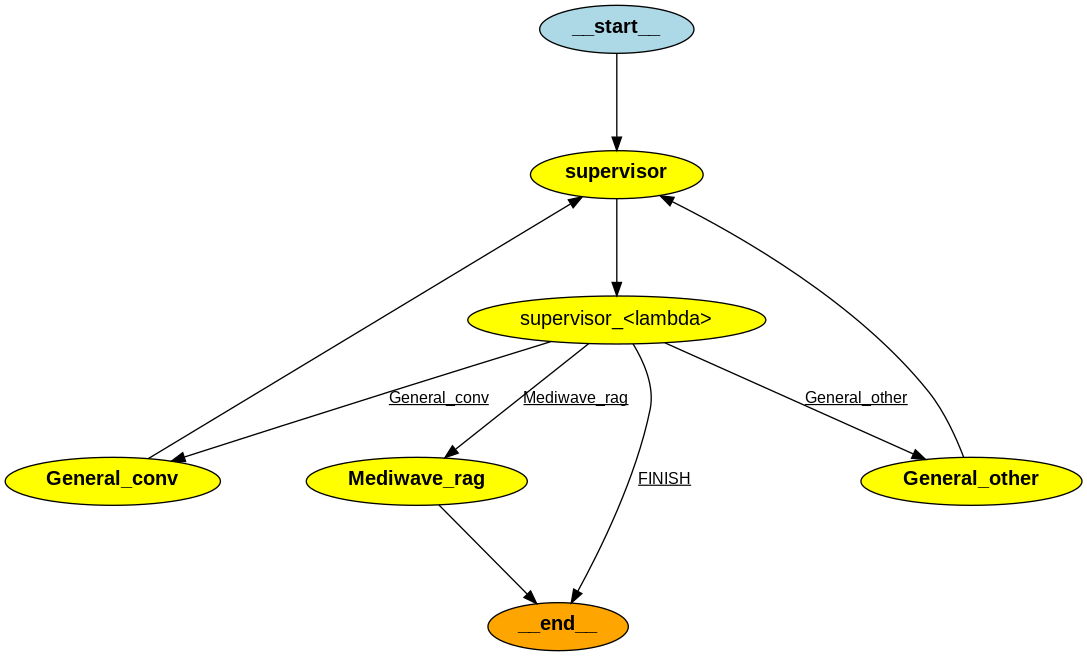

In [2]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [ ]:
# for s in graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content="tell me about mediwave."
#             )
#         ],
#     },
#     {"recursion_limit": 150},
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")


# Travel crew 

In [1]:
from  grp_travel_crew_ai.grp_travel_crewai import travel_crew


travel_result = travel_crew(input='suggest me some tourist spots in pondicherry')

print(travel_result)

 [DEBUG]: Working Agent: Crew Manager


> Entering new CrewAgentExecutor chain...
First, I need to gather information about Pondicherry and identify potential tourist spots. To do this, I'll delegate the task of researching Pondicherry to one of my coworkers.

Action: Delegate work to co-worker
Action Input: {
    "coworker": "City Selection Expert",
    "task": "Research Pondicherry and its tourist spots.",
    "context": "Pondicherry is a city in India. It has a rich history, culture, and unique architecture."
}

> Entering new CrewAgentExecutor chain...
I need to research Pondicherry and its tourist spots.

Action: Search the internet
Action Input: {
    "query": "Pondicherry tourist spots"
} 

Sorry, I couldn't find anything about that, there could be an error with you serper api key.

Thought: 
I need to research Pondicherry and its tourist spots.

Action: Search the internet
Action Input: {
    "query": "Pondicherry tourist attractions"
} 

Title: THE 15 BEST Things to Do in Pond